In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
import pickle

import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(rc={'figure.figsize':(14, 7)})

In [4]:
with open('../scraping/stats_salaries_cap.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))

<AxesSubplot:xlabel='salary_category', ylabel='count'>

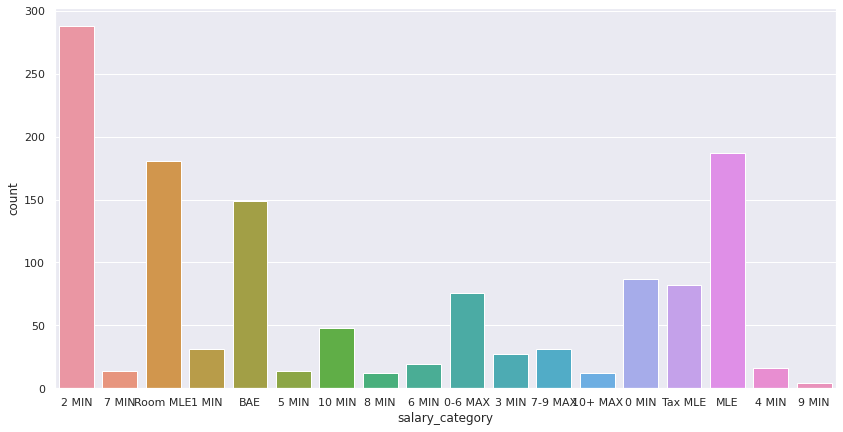

In [7]:
sns.countplot(x='salary_category', data=data)

# Manual sampling for balanced salary categories

In [19]:
import random

In [13]:
data.loc[data['salary_category'].apply(lambda x: 'BAE' in x)].shape

(149, 134)

In [14]:
data.loc[data['salary_category'].apply(lambda x: 'MLE' in x)].shape

(450, 134)

In [16]:
data.loc[data['salary_category'].apply(lambda x: 'MIN' in x)].shape

(560, 134)

In [17]:
data.loc[data['salary_category'].apply(lambda x: 'MAX' in x)].shape

(119, 134)

## Train, validation and Test

In [86]:
seed = 45

In [87]:
random.seed(seed)

In [20]:
mle_indices = data.loc[data['salary_category'].apply(lambda x: 'MLE' in x)].index
max_indices = data.loc[data['salary_category'].apply(lambda x: 'MAX' in x)].index
min_indices = data.loc[data['salary_category'].apply(lambda x: 'MIN' in x)].index
bae_indices = data.loc[data['salary_category'].apply(lambda x: 'BAE' in x)].index

In [88]:
test_mle = random.sample(list(mle_indices), int(len(mle_indices)*0.2)) 
train_mle = [i for i in mle_indices if i not in test_mle]
val_mle = random.sample(list(train_mle), int(len(train_mle)*0.2))
train_mle = [i for i in train_mle if i not in val_mle]

len(test_mle) + len(train_mle) + len(val_mle)

450

In [89]:
test_max = random.sample(list(max_indices), int(len(max_indices)*0.1)) 
train_max = [i for i in max_indices if i not in test_max]
val_max = random.sample(list(train_max), int(len(train_max)*0.1))
train_max = [i for i in train_max if i not in val_max]

len(test_max) + len(train_max) + len(val_max)

119

In [90]:
test_bae = random.sample(list(bae_indices), int(len(bae_indices)*0.15)) 
train_bae = [i for i in bae_indices if i not in test_bae]
val_bae = random.sample(list(train_bae), int(len(train_bae)*0.15))
train_bae = [i for i in train_bae if i not in val_bae]

len(test_bae) + len(train_bae) + len(val_bae)

149

In [91]:
test_min = random.sample(list(min_indices), int(len(min_indices)*0.2)) 
train_min = [i for i in min_indices if i not in test_min]
val_min = random.sample(list(train_min), int(len(train_min)*0.2))
train_min = [i for i in train_min if i not in val_min]

len(test_min) + len(train_min) + len(val_min)

560

In [92]:
train_indices = sum([train_min, train_bae, train_max, train_mle], [])
val_indices = sum([val_min, val_bae, val_max, val_mle], [])
test_indices = sum([test_min, test_bae, test_max, test_mle], [])

In [93]:
X = data.drop(columns=['Player', 'previous season', 'Next season', 'Salary',
       'salary_cap', 'cap_usage', 'salary_category', 'season_x', 'season_y'])
X = pd.concat([X.drop('Pos', axis=1), pd.get_dummies(X.Pos)], axis=1)

y = data['cap_usage']

In [94]:
X_train, X_val, X_test = X.loc[train_indices], X.loc[val_indices], X.loc[test_indices]
y_train, y_val, y_test = y.loc[train_indices], y.loc[val_indices], y.loc[test_indices]

# Feature Selection

In [95]:
select = SelectKBest(f_regression, k=90)

In [96]:
best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(25)['features'])

In [97]:
X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]

In [98]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [99]:
evaluate(lr.predict(X_val), y_val)

r^2:  0.6385417089937095
mse:  0.0013223693889000377
variance_score:  0.641362806255303


In [100]:
evaluate(lr.predict(X_test), y_test)

r^2:  0.5672925369633108
mse:  0.001261243642006599
variance_score:  0.5729557359096795


In [101]:
ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=5)

In [102]:
evaluate(ridge_cv.predict(X_val), y_val)

r^2:  0.6379446491034557
mse:  0.0013245536899434958
variance_score:  0.6407276738808106


In [103]:
evaluate(ridge_cv.predict(X_test), y_test)

r^2:  0.5718249011349537
mse:  0.0012480328333585903
variance_score:  0.5778603683402892


# Light GBM

In [71]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [64]:
import lightgbm as lgb

In [104]:
lgb_toy = lgb.LGBMRegressor(boosting_type = 'dart', 
                            n_estimators=2500)

In [105]:
lgb_toy.fit(X_train, y_train)

LGBMRegressor(boosting_type='dart', n_estimators=2500)

In [106]:
r2_score(y_val, lgb_toy.predict(X_val))

0.6023364585004931

In [107]:
r2_score(y_test, lgb_toy.predict(X_test))

0.6259032533793123

In [146]:
boosting_type = ['gbdt', 'dart', 'goss', 'rf']

objective = ['regression', 'huber', 'fair', 'poisson', 'quantile']

num_leaves = range(1, 10, 1)

min_child_weight = range(1, 50, 10)

learning_rate = [1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 5e-2, 1e-1, 0.2, 0.3]

min_split_gain = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

lightgbm_grid = {'num_leaves': num_leaves,
                 'min_child_weight': min_child_weight,
                 'objective': objective}

In [147]:
lightgbm = lgb.LGBMRegressor(boosting_type = 'dart', n_estimators = 1000)

lightgbm_random = RandomizedSearchCV(estimator = lightgbm,
                                     param_distributions = lightgbm_grid, n_iter = 400, cv = 5,
                                     verbose=3, n_jobs = -1, random_state = seed)
# Fit the random search model
lightgbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(boosting_type='dart',
                                           n_estimators=1000),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'min_child_weight': range(1, 50, 10),
                                        'num_leaves': range(1, 10),
                                        'objective': ['regression', 'huber',
                                                      'fair', 'poisson',
                                                      'quantile']},
                   random_state=45, verbose=3)

In [148]:
r2_score(y_val, lightgbm_random.predict(X_val))

0.6672184701022486

In [149]:
r2_score(y_test, lightgbm_random.predict(X_test))

0.6263005672236419

In [150]:
lightgbm_random.best_estimator_

LGBMRegressor(boosting_type='dart', min_child_weight=41, n_estimators=1000,
              num_leaves=5, objective='fair')

In [159]:
with open('../scraping/salary_categories_dict.pickle', 'rb') as handle:
    salary_categories_dict = pickle.load(handle)

In [162]:
def assign_category(row, index='pred_salary'):
    season_dict = salary_categories_dict[row['Next season']]
    sorted_season_dict = dict(sorted(season_dict.items(), key=lambda item: abs(item[0] - row[index])))
    return list(sorted_season_dict.values())[0]

In [171]:
tmp = data.loc[y_test.index][['Player', 'previous season', 'cap_usage', 'salary_cap',  'Salary', 'salary_category', 'Next season']]
tmp['pred_cap_usage'] = lightgbm_random.predict(X_test)
tmp['pred_salary'] = tmp['pred_cap_usage'] * tmp['salary_cap']
tmp['pred_salary'] = tmp['pred_salary'].apply(int)
tmp = tmp[['Player', 'previous season', 'salary_cap', 'cap_usage', 'pred_cap_usage', 'Salary', 'salary_category', 'pred_salary', 'Next season']]
tmp['Salary'] = tmp['Salary'].apply(int)
tmp['salary_category_pred'] = tmp.apply(assign_category, axis=1)
tmp.drop(['Next season'], inplace=True, axis=1)

In [175]:
tmp[100:150]

,Player,previous season,salary_cap,cap_usage,pred_cap_usage,Salary,salary_category,pred_salary,salary_category_pred
632,Jimmer Fredette,2013-14,63065000,0.014513,0.013283,915243,2 MIN,837715,1 MIN
661,Rasual Butler,2013-14,63065000,0.014513,0.015155,915243,2 MIN,955731,3 MIN
930,Raymond Felton,2016-17,99093000,0.014848,0.054685,1471382,2 MIN,5418932,Tax MLE
966,Dwyane Wade,2017-18,101869000,0.014848,0.043395,1512601,2 MIN,4420564,Room MLE
754,Michael Beasley,2014-15,70000000,0.004379,0.030198,306527,0 MIN,2113840,BAE
268,Jason Collins,2008-09,57700000,0.014307,0.022314,825497,2 MIN,1287527,10 MIN
1224,Dewayne Dedmon,2020-21,125000000,0.013353,0.021255,1669178,2 MIN,2656928,9 MIN
722,Jason Richardson,2014-15,70000000,0.013533,0.020153,947276,2 MIN,1410729,9 MIN
1290,Tony Snell,2020-21,125000000,0.013353,0.030901,1669178,2 MIN,3862607,BAE
400,Carldell Johnson,2011-12,58044000,0.008159,0.012989,473604,0 MIN,753939,1 MIN


In [177]:
tmp['salary_category'] = tmp['salary_category'].apply(lambda x: x[-3:])
tmp['salary_category_pred'] = tmp['salary_category_pred'].apply(lambda x: x[-3:])

In [180]:
np.sum(tmp['salary_category'] == tmp['salary_category_pred']) / tmp.shape[0]

0.6468085106382979